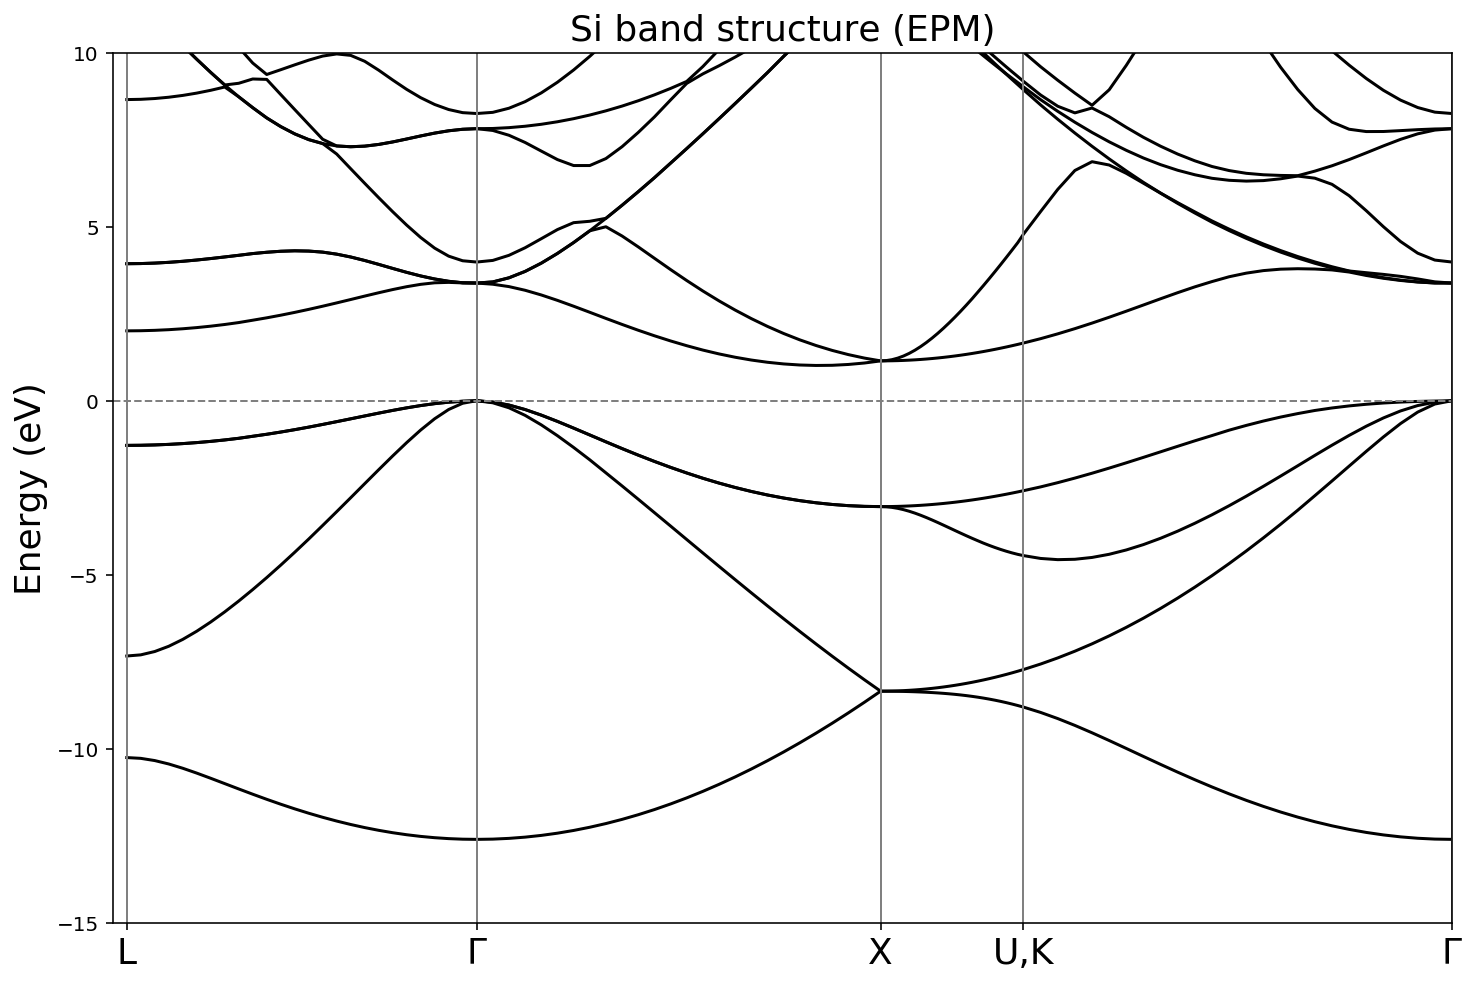

In [11]:
#!/usr/bin/env python3

import numpy as np
from matplotlib import pyplot as plt
import scipy.interpolate
from ipywidgets import interact, FloatSlider

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Everything is in atomic Rydberg units, i.e.,
# 1/(4πε_0) = 1 = e^2/2 = 2 m_e = ℏ

# The length in atomic units is the Bohr radius, which in angstroms is:
bohr = 0.52917721092
# The energy unit in atomic units is the Rydberg energy, which in eV is:
ryd = 13.60569253
# Maximum reciprocal lattice vector used for the calculations
Gmax = 3
# Energy cutoff, in rydberg, for the expansion of the Hamiltonian in
# reciprocal lattice vectors. We only include lattice vectors such that
# |k + G|^2 < E_cutoff
E_cutoff = 9.0


# Unit cell, in bohrs. Each row is the primitive lattice vector
a = 10.26
cell = np.array([[.0, .5, .5],
                 [.5, .0, .5],
                 [.5, .5, .0]]) * a


# Reciprocal cell
rec_cell = 2 * np.pi * np.linalg.inv(cell).T

# Construct a list of G vector in crystal coordinates, shape (ng,3)
gvectors_crys = np.mgrid[-Gmax:Gmax+1,-Gmax:Gmax+1,-Gmax:Gmax+1].reshape((3,-1)).T
num_g = gvectors_crys.shape[0]
print('Maximum number of G vectors to include:', num_g)

# G vectors in cartesian coordinates as G_cart = G_crys [g1 g2 g3]^T
gvectors_cart = gvectors_crys.dot(rec_cell)

# List of atoms.
# Each line contains the symbol and the position, in crystal coordinates.
atoms = [
    ['Si', [ .125,  .125,  .125]],
    ['Si', [-.125, -.125, -.125]]
    ]

# Special points for FCC an cell:
Γ = np.pi/a * np.array([0,0,0])
X = np.pi/a * np.array([2,0,0])
L = np.pi/a * np.array([1,1,1])
W = np.pi/a * np.array([2,1,0])
U = np.pi/a * np.array([2,1/2,1/2])
K = np.pi/a * np.array([3/2,3/2,0])

# Path in the Brillouin zone for the band structure plot
# and number of points between high-symmetry k-points
path = [L, Γ, X, (U,K), Γ]
labels = ['L', 'Γ', 'X', 'U,K', 'Γ']
Npts = 25
segments = []
for i in range(len(path)-1):
    p_left = path[i]
    p_right = path[i+1]
    if isinstance(p_left, tuple):
      p_left = p_left[-1]
    if isinstance(p_right, tuple):
      p_right = p_right[0]
    segments.append(np.array((p_left,p_right)))
#segments = [np.array((path[i], path[i+1])) for i in range(len(path)-1)]


def epm_plot(V3=-0.2241, V8=0.052, V11=0.0724):
    # List of atomic form factors, in Ry. Each dictionary key is |G|^2
    # in Ry^2 by (2pi/a)^2.
    form_factors = {
        'Si': {0:0, 3:V3, 8:V8, 11:V11}
        }

    # Compute the potential
    # Vp = 1/w \sum_t e^{-iG.t} V_t[G]
    # Compute all possible G - G`
    delta_g_crys = gvectors_crys[:,None,:] - gvectors_crys[None,:,:]
    delta_g_cart = gvectors_cart[:,None,:] - gvectors_cart[None,:,:]
    delta_g2 = np.sum(delta_g_cart**2, axis=-1) * (a/(2*np.pi))**2
    delta_g2 = np.round(np.sum(delta_g_cart**2, axis=-1) * (a/(2*np.pi))**2).astype(int)
    Vp = np.zeros((num_g,num_g), dtype=np.complex128)
    for iatom in range(len(atoms)):
        element = atoms[iatom][0]
        tau_crys = atoms[iatom][1]
        form_factor = form_factors[element]
        for g2 in form_factor.keys():
            cond = delta_g2 == g2
            Vp[cond] += np.exp(-1.j*2*np.pi*delta_g_crys[cond].dot(tau_crys)) * form_factor[g2]
    Vp /= len(atoms)

    def solve_hamiltonian(kpoint):
        # Kinetic energy |G+k|^2, in ryd.
        ham = np.empty_like(Vp)
        g_plus_k_cart = gvectors_cart + kpoint[None,:]
        e_kin = np.sum(g_plus_k_cart**2, axis=1)
        ham.fill(0j)
        np.fill_diagonal(ham, e_kin)
        ham += Vp
        cond = e_kin < E_cutoff
        ham = ham[cond,:][:,cond]
        #print(np.shape(np.linalg.eigvalsh(ham)))
        return np.linalg.eigvalsh(ham)

    evals = []
    dks = []
    #last_k_point = segments[0][0]
    dk = None
    for isegment, segment in enumerate(segments):
        f_interp = scipy.interpolate.interp1d([0,1], segment.T)
        interp_pts = np.linspace(0, 1, Npts, endpoint=False)
        #last_k_point = segments[isegment][0]
        if isegment==len(segments)-1:
            interp_pts = np.append(interp_pts, 1)
        k_path = f_interp(interp_pts)
        if dk is None:
            dk = np.linalg.norm(k_path[:,1] - k_path[:,0])
        for k_point in k_path.T:
            dks.append(dk)
            evals_k = solve_hamiltonian(k_point)
            evals.append(evals_k[:20])
            last_k_point = k_point
            dk = np.linalg.norm(k_path[:,1] - k_path[:,0])
    x = np.cumsum(dks)
    x /= x[-1]

    evals = np.array(evals) * ryd
    evals -= np.amax(evals[:,3])
    plt.figure(figsize=(12,8))
    plt.title('Si band structure (EPM)', size=18)
    plt.plot(x, evals, color='k')
    plt.axhline(0, ls='--', lw=1, color='0.5')
    plt.xlim(0, 1)
    plt.ylim(-6, 7)
    plt.ylim(-15, 10)
    x_labels = x[Npts*np.arange(len(path))]
    for x_label, label in zip(x_labels, labels):
        plt.axvline(x_label, ls='-', lw=1, color='0.5')
    plt.xticks(x_labels, labels, size=18)
    plt.ylabel('Energy (eV)', size=18)
    plt.show()

interact(epm_plot,
         V3=FloatSlider(value=-0.2241, min=-0.5, max=0.5, step=0.025, readout_format='.3f', continuous_update=False),
         V8=FloatSlider(value=0.052, min=-0.50, max=0.5, step=0.025, readout_format='.3f', continuous_update=False),
         V11=FloatSlider(value=0.0724, min=-0.5, max=0.5, step=0.025, readout_format='.3f', continuous_update=False)
         );

In [12]:
V3=-0.2241
V8=0.052
V11=0.0724
form_factors = {
        'Si': {0:0, 3:V3, 8:V8, 11:V11}
        }

# Compute the potential
# Vp = 1/w \sum_t e^{-iG.t} V_t[G]
# Compute all possible G - G`
delta_g_crys = gvectors_crys[:,None,:] - gvectors_crys[None,:,:]
delta_g_cart = gvectors_cart[:,None,:] - gvectors_cart[None,:,:]
delta_g2 = np.sum(delta_g_cart**2, axis=-1) * (a/(2*np.pi))**2
delta_g2 = np.round(np.sum(delta_g_cart**2, axis=-1) * (a/(2*np.pi))**2).astype(int)
Vp = np.zeros((num_g,num_g), dtype=np.complex128)
for iatom in range(len(atoms)):
    element = atoms[iatom][0]
    tau_crys = atoms[iatom][1]
    form_factor = form_factors[element]
    for g2 in form_factor.keys():
        cond = delta_g2 == g2
        Vp[cond] += np.exp(-1.j*2*np.pi*delta_g_crys[cond].dot(tau_crys)) * form_factor[g2]
Vp /= len(atoms)

def solve_hamiltonian(kpoint):
    # Kinetic energy |G+k|^2, in ryd.
    ham = np.empty_like(Vp)
    g_plus_k_cart = gvectors_cart + kpoint[None,:]
    e_kin = np.sum(g_plus_k_cart**2, axis=1)
    ham.fill(0j)
    np.fill_diagonal(ham, e_kin)
    ham += Vp
    cond = e_kin < E_cutoff
    ham = ham[cond,:][:,cond]
    #print(np.shape(np.linalg.eigvalsh(ham)))
    return np.linalg.eigvalsh(ham)

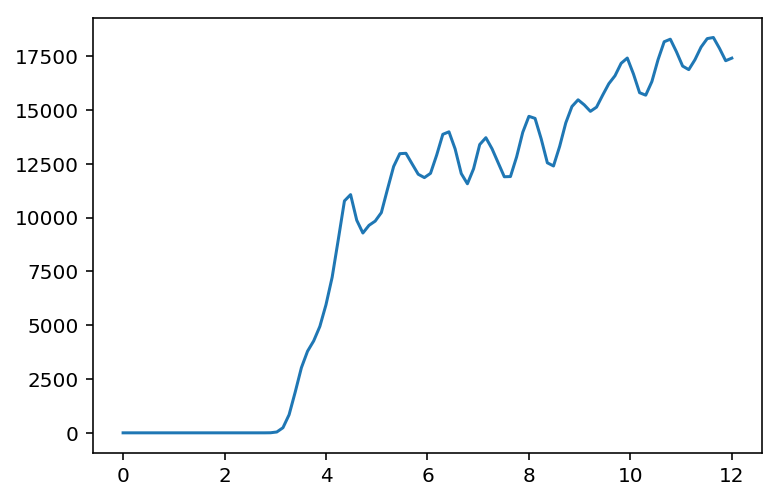

In [78]:
rec_cell
N = 30
numE = 100
sigma = 0.2
Elist = np.linspace(0, 12, numE)
Jvc = np.zeros(np.shape(Elist))
solve_hamiltonian(np.array([0,0,0]))* ryd

b1 = rec_cell[0]
b2 = rec_cell[1]
b3 = rec_cell[2]

for n1 in range(N):
    for n2 in range(N):
        for n3 in range(N):
            k = n1/N * b1 + n2/N * b2 + n3/N * b3
            evals = solve_hamiltonian(k.T)* ryd
            for v in range(4):
                for c in range(4, 14):
                    Jvc += np.exp(-(evals[c] - evals[v] - Elist)**2/(sigma)**2) 
                    
plt.plot(Elist, Jvc)
plt.show()

/Users/alexwhite/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


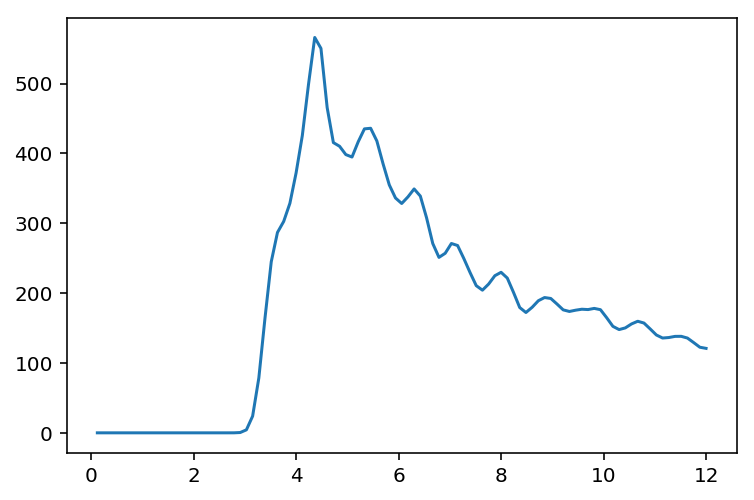

In [81]:
plt.plot(Elist, Jvc*1/Elist**2)